In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize

# Configuration parameters
FREQ = 'QE'  # 'ME' for monthly, 'QE' for quarterly, 'YE' for yearly
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Modern Portfolio Theory: The Science of Diversification

## The Problem: Don't Put All Your Eggs in One Basket

Imagine you're an investor in 2008. You could have:
- **Put everything in stocks** (S&P 500): Lost 37% in one year
- **Put everything in bonds**: Gained 5.2% that year  
- **Put everything in gold**: Gained 4.3% that year

But what if you had diversified? This notebook explores **Modern Portfolio Theory** - Harry Markowitz's Nobel Prize-winning framework for optimal portfolio construction.

## The Core Insight

Diversification doesn't just reduce risk - it can actually **improve your risk-adjusted returns**. By combining assets that don't move in perfect sync, we can create portfolios that offer better returns for the same level of risk, or the same returns with less risk.

## Our Investment Universe

We'll work with three key asset classes:
- **🏆 Gold (GC-F)**: The classic safe haven and inflation hedge
- **📈 S&P 500 (SPY)**: The engine of economic growth  
- **🏛️ US Treasury Bonds (IEF)**: The bedrock of stability

Let's load the data and see what story these assets tell...


In [26]:
base_dir = os.path.join("..", "data")

assets_paths = [
    os.path.join(base_dir, "commodities", 'GC-F.csv'),
    # os.path.join(base_dir, "crypto", 'BTC-USD.csv'),
    os.path.join(base_dir, "sp500_index", 'SPY.csv'),
    os.path.join(base_dir, "us_bonds", 'IEF.csv')
]

In [27]:
def read_data(paths):
    dataframes = []
    for path in paths:
        df = pd.read_csv(path)
        df.name = os.path.splitext(os.path.basename(path))[0]  # Store asset name in DataFrame
        dataframes.append(df)
    return dataframes

In [28]:
dataframes = read_data(assets_paths)

In [29]:
def plot_dfs(dfs, plot_type='line', resample_freq="YE"):
    if plot_type == 'line':
        for df in dfs:
            df.plot(x='Date', y='Close', title=f'{df.name} Price Over Time')
    elif plot_type == 'hist of yearly returns':
        for df_cur in dfs:
            df = df_cur.copy()
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df = df.resample(resample_freq).last()
            df['return'] = df['Close'].pct_change()
            df.name = df_cur.name  # Preserve the name attribute
            df.hist(column='return')
            # plot mean line
            plt.axvline(df["return"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df["return"].mean()*100:.2f}%')
            plt.title(f'{df.name} Returns Distribution')
            plt.legend()

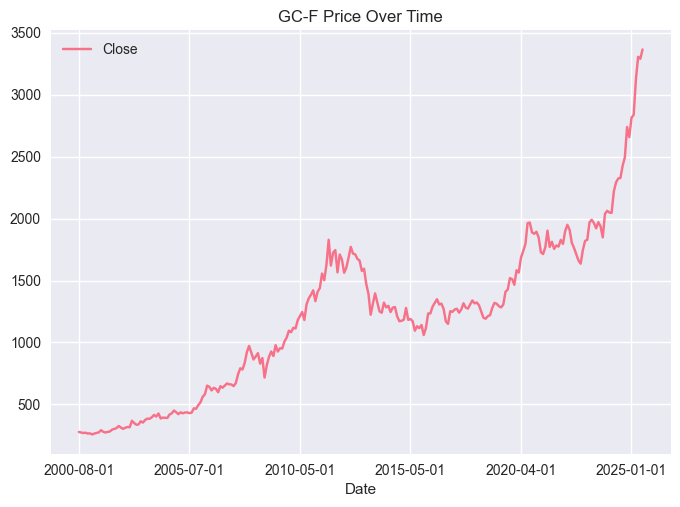

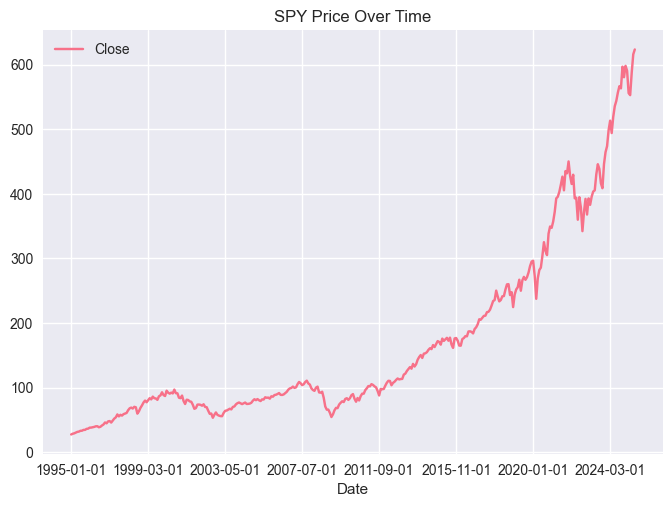

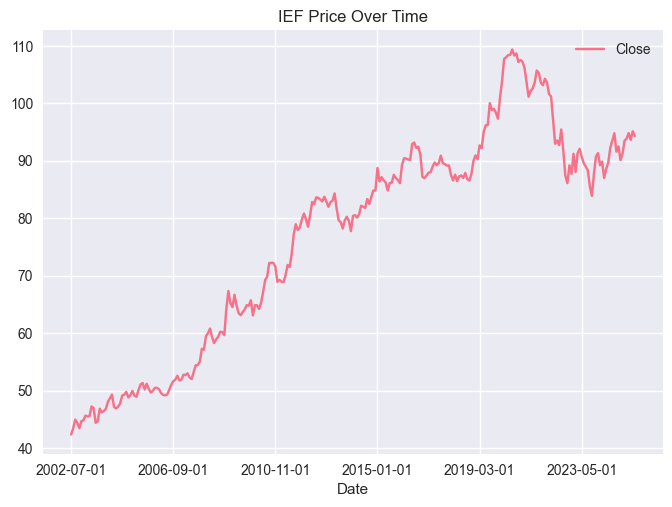

In [30]:
plot_dfs(dataframes)

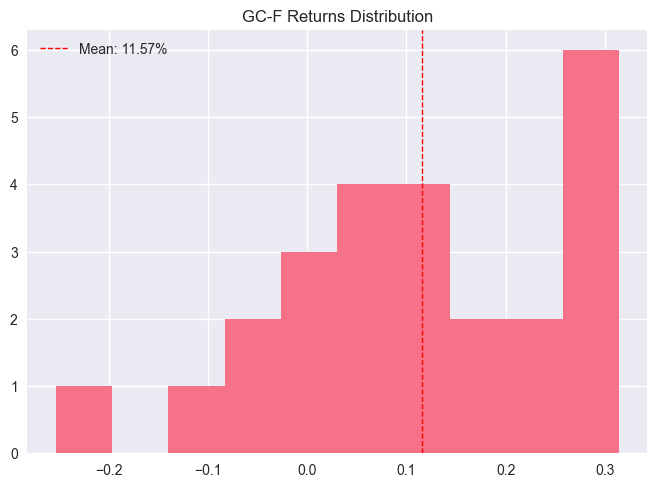

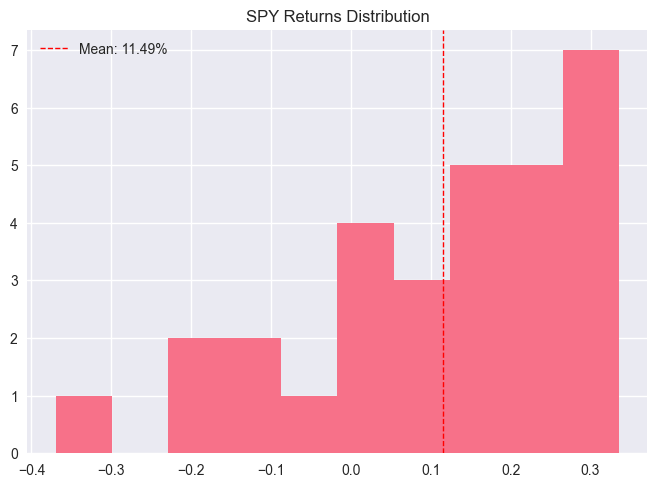

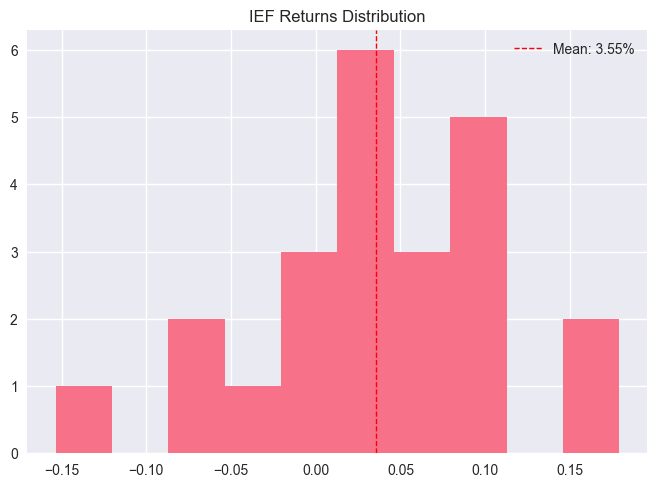

In [31]:
plot_dfs(dataframes, plot_type='hist of yearly returns', resample_freq="YE")

In [32]:
def get_dates_intersection(dfs):
    date_sets = [set(df['Date']) for df in dfs]
    common_dates = set.intersection(*date_sets)
    return sorted(common_dates)

In [33]:
common_dates = get_dates_intersection(dataframes)
print(f"Common dates across all datasets: {len(common_dates)}")
print(f"Start date {common_dates[0]}")
print(f"End date {common_dates[-1]}")

Common dates across all datasets: 236
Start date 2002-07-01
End date 2025-07-01


In [34]:
def get_dataframes_by_dates(dfs, dates):
    filtered_dfs = []
    for df in dfs:
        filtered_df = df[df['Date'].isin(dates)].copy()
        filtered_df = filtered_df.sort_values(by='Date')
        filtered_df.name = df.name  # Preserve the name attribute
        filtered_dfs.append(filtered_df)
    return filtered_dfs

In [35]:
filtered_dataframes = get_dataframes_by_dates(dataframes, common_dates)

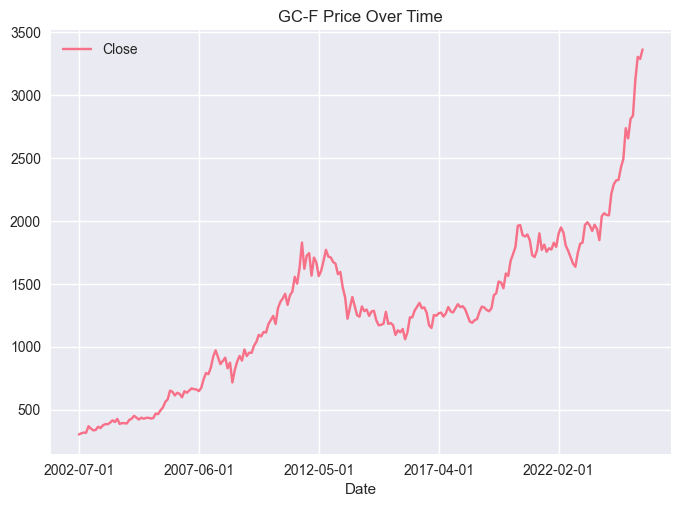

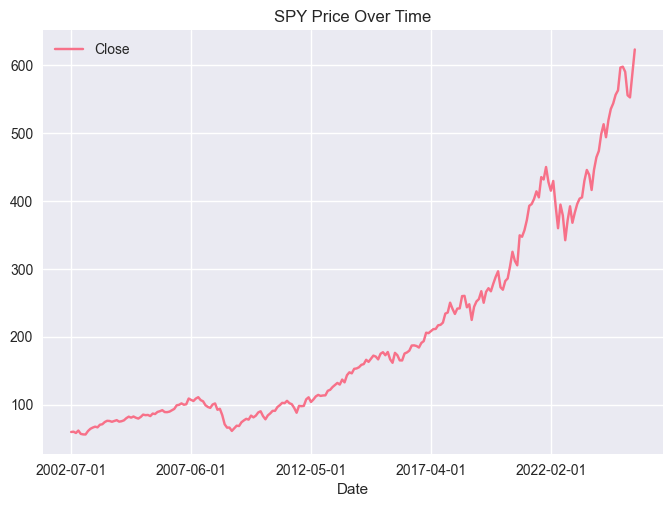

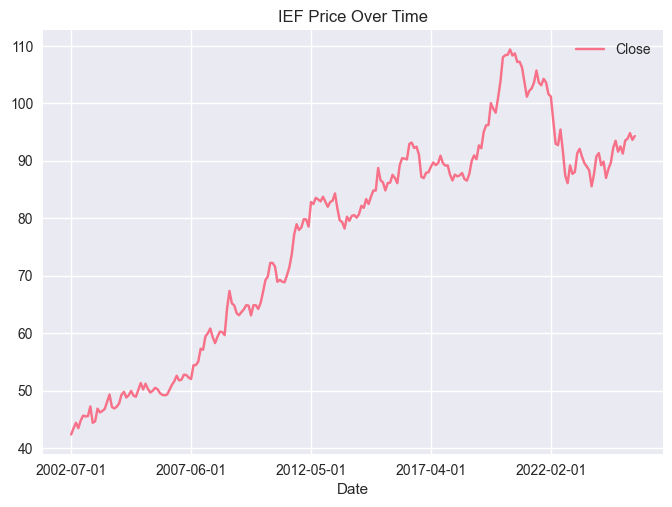

In [36]:
plot_dfs(filtered_dataframes)

In [37]:
def fill_annual_returns(dfs):
    processed_data = {}
    for df_cur in dfs:
        df = df_cur.copy()
        df.name = df_cur.name  # Preserve the name attribute
        # Ensure 'Date' is datetime and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        # Resample all columns to specified frequency, taking the last value
        annual_df = df.resample(FREQ).last()
        # Calculate return based on 'Close' (fix deprecation warning)
        annual_df['return'] = annual_df['Close'].pct_change(fill_method=None)
        processed_data[df.name] = annual_df[['Close', 'return']].dropna()
    return processed_data

In [38]:
processed_data = fill_annual_returns(filtered_dataframes)

<Axes: >

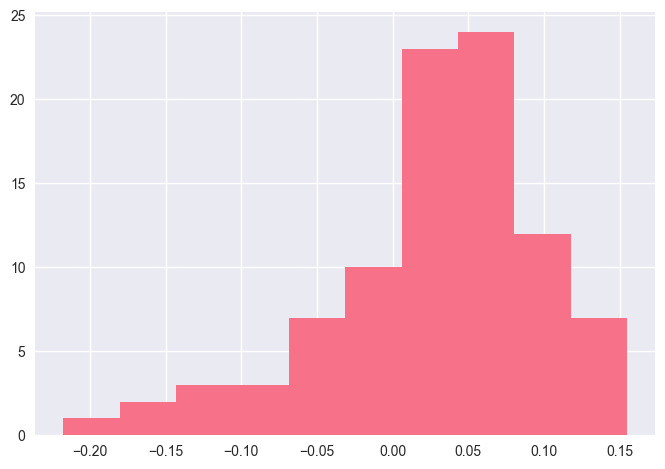

In [39]:
processed_data["SPY"]['return'].hist()

## The Mathematics of Portfolio Theory

### Core Formulas

**Portfolio Return**: $ r_p = \sum_{i=1}^{n} w_i \cdot r_i $

**Portfolio Risk (Variance)**: $ \sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \sigma_{ij} = w^T \Sigma w $

**Sharpe Ratio**: $ SR = \frac{r_p - r_f}{\sigma_p} $ where $ r_f = 2\% $ (our risk-free rate)

Where:
- $w_i$ = weight of asset i in portfolio
- $r_i$ = expected return of asset i  
- $\sigma_{ij} $ = covariance between assets i and j
- $\Sigma $ = covariance matrix
- $r_f $ = risk-free rate

### The Magic of Diversification

The key insight: when assets don't move perfectly together (correlation < 1), the portfolio variance is **less than** the weighted average of individual variances. This is why diversification works!


In [40]:
def build_returns_matrix(processed_data):
    """Build returns matrix from processed data"""
    returns_data = []
    asset_names = []
    
    for asset_name, df in processed_data.items():
        returns_data.append(df['return'].values)
        asset_names.append(asset_name)
    
    returns_matrix = np.array(returns_data).T  # Shape: (n_periods, n_assets)
    return returns_matrix, asset_names

def calculate_portfolio_statistics(returns_matrix, asset_names, freq=FREQ):
    """Calculate key portfolio statistics"""
    
    # Calculate frequency multiplier for annualization
    if freq == 'ME':  # Monthly
        periods_per_year = 12
    elif freq == 'QE':  # Quarterly  
        periods_per_year = 4
    elif freq == 'YE':  # Yearly
        periods_per_year = 1
    else:
        periods_per_year = 1  # Default
    
    # Calculate statistics
    mean_returns = np.mean(returns_matrix, axis=0) * periods_per_year  # Annualized
    cov_matrix = np.cov(returns_matrix.T) * periods_per_year  # Annualized
    std_returns = np.sqrt(np.diag(cov_matrix))  # Annualized volatility
    sharpe_ratios = (mean_returns - RISK_FREE_RATE) / std_returns
    
    # Create summary DataFrame
    stats_df = pd.DataFrame({
        'Asset': asset_names,
        'Expected Return': mean_returns,
        'Volatility': std_returns,
        'Sharpe Ratio': sharpe_ratios
    })
    
    return stats_df, mean_returns, cov_matrix, std_returns

# Build returns matrix and calculate statistics
returns_matrix, asset_names = build_returns_matrix(processed_data)
stats_df, mean_returns, cov_matrix, std_returns = calculate_portfolio_statistics(returns_matrix, asset_names)

print("📊 Portfolio Statistics (Annualized)")
print("=" * 50)
print(stats_df.round(4))


📊 Portfolio Statistics (Annualized)
  Asset  Expected Return  Volatility  Sharpe Ratio
0  GC-F           0.1145      0.1405        0.6725
1   SPY           0.1141      0.1466        0.6419
2   IEF           0.0363      0.0709        0.2296


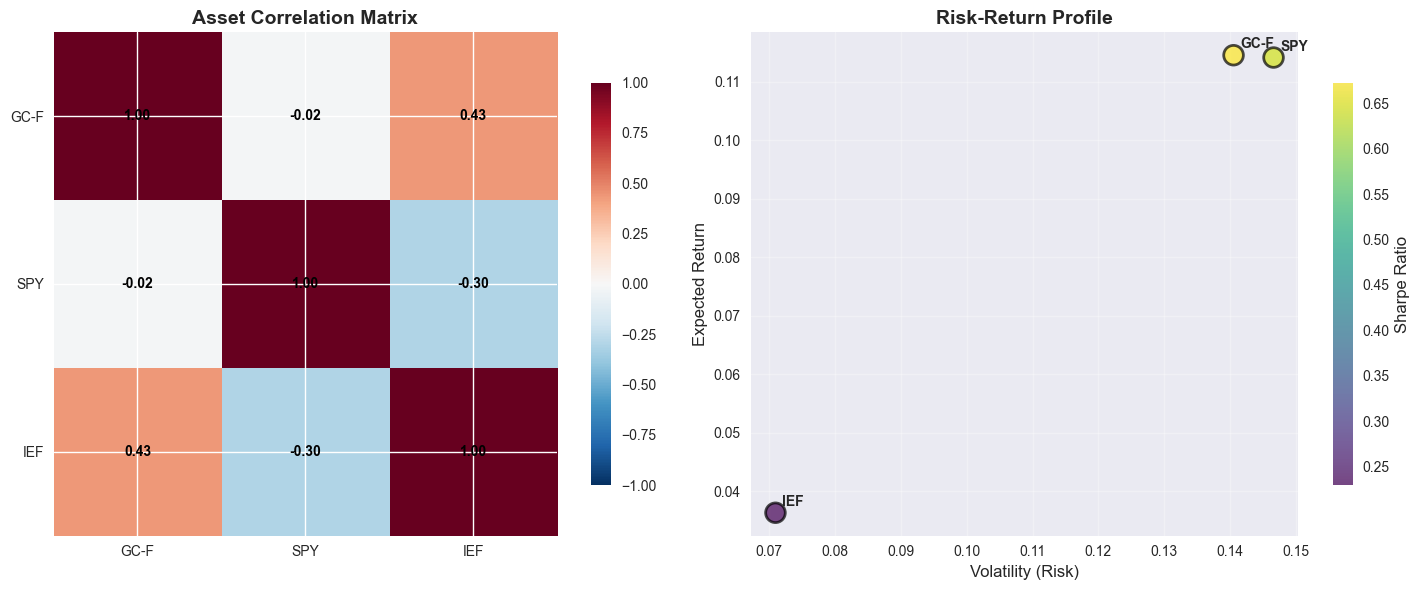


🔍 Key Observations:
• Gold and Bonds correlation: 0.435
• Gold and Stocks correlation: -0.023
• Bonds and Stocks correlation: -0.303
• Best individual Sharpe ratio: GC-F (0.673)


In [41]:
# Visualize correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Correlation heatmap
correlation_matrix = np.corrcoef(returns_matrix.T)
im = ax1.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_xticks(range(len(asset_names)))
ax1.set_yticks(range(len(asset_names)))
ax1.set_xticklabels(asset_names)
ax1.set_yticklabels(asset_names)
ax1.set_title('Asset Correlation Matrix', fontsize=14, fontweight='bold')

# Add correlation values to the heatmap
for i in range(len(asset_names)):
    for j in range(len(asset_names)):
        text = ax1.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax1, shrink=0.8)

# Risk-Return scatter plot
scatter = ax2.scatter(std_returns, mean_returns, s=200, alpha=0.7, c=stats_df['Sharpe Ratio'], 
                     cmap='viridis', edgecolors='black', linewidth=2)

for i, asset in enumerate(asset_names):
    ax2.annotate(asset, (std_returns[i], mean_returns[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

ax2.set_xlabel('Volatility (Risk)', fontsize=12)
ax2.set_ylabel('Expected Return', fontsize=12)
ax2.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add colorbar for Sharpe ratio
cbar = plt.colorbar(scatter, ax=ax2, shrink=0.8)
cbar.set_label('Sharpe Ratio', fontsize=12)

plt.tight_layout()
plt.show()

print("\n🔍 Key Observations:")
print(f"• Gold and Bonds correlation: {correlation_matrix[0,2]:.3f}")
print(f"• Gold and Stocks correlation: {correlation_matrix[0,1]:.3f}")  
print(f"• Bonds and Stocks correlation: {correlation_matrix[1,2]:.3f}")
print(f"• Best individual Sharpe ratio: {asset_names[np.argmax(stats_df['Sharpe Ratio'])]} ({stats_df['Sharpe Ratio'].max():.3f})")


## Exploring the Possibility Space: Random Portfolios

Before we find the optimal portfolios, let's explore what's possible. We'll generate 10,000 random portfolio combinations and see how they perform. This gives us the "cloud" of all possible portfolios - some good, some bad, but all achievable.


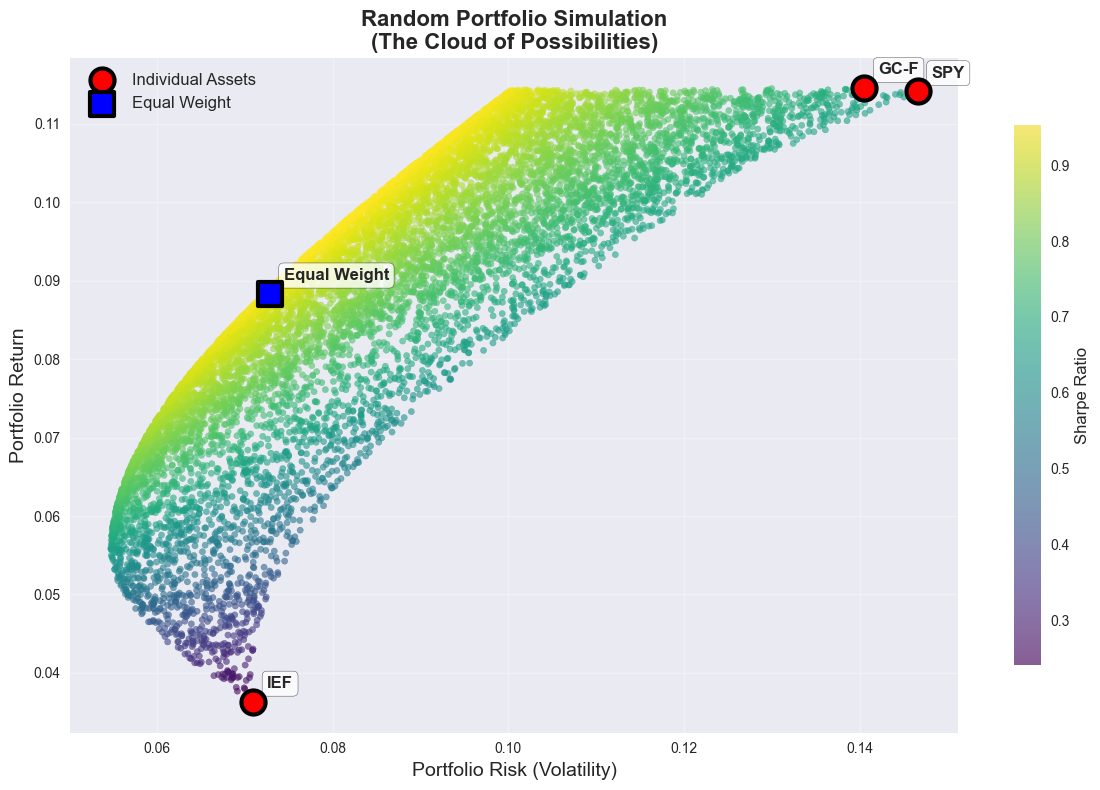

📈 Random Portfolio Statistics:
• Best Sharpe ratio found: 0.9526
• Worst Sharpe ratio found: 0.2409
• Equal weight portfolio: Return=0.0883, Risk=0.0728, Sharpe=0.9380
• Range of returns: 0.0370 to 0.1145
• Range of risks: 0.0547 to 0.1450


In [42]:
def generate_random_portfolios(n_portfolios=10000, n_assets=len(asset_names)):
    """Generate random portfolio weights and calculate their statistics"""
    
    np.random.seed(42)  # For reproducibility
    
    # Generate random weights (Dirichlet distribution ensures they sum to 1)
    random_weights = np.random.dirichlet(np.ones(n_assets), n_portfolios)
    
    # Calculate portfolio returns and risks
    portfolio_returns = np.dot(random_weights, mean_returns)
    portfolio_risks = np.array([np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) for w in random_weights])
    portfolio_sharpes = (portfolio_returns - RISK_FREE_RATE) / portfolio_risks
    
    return random_weights, portfolio_returns, portfolio_risks, portfolio_sharpes

def plot_random_portfolios(portfolio_returns, portfolio_risks, portfolio_sharpes):
    """Plot the cloud of random portfolios"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create scatter plot colored by Sharpe ratio
    scatter = ax.scatter(portfolio_risks, portfolio_returns, 
                        c=portfolio_sharpes, cmap='viridis', alpha=0.6, s=20)
    
    # Add individual assets
    ax.scatter(std_returns, mean_returns, s=300, marker='o', 
              c='red', edgecolors='black', linewidth=3, label='Individual Assets', zorder=5)
    
    # Annotate individual assets
    for i, asset in enumerate(asset_names):
        ax.annotate(asset, (std_returns[i], mean_returns[i]), 
                   xytext=(10, 10), textcoords='offset points', 
                   fontsize=12, fontweight='bold', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add equal weight portfolio
    equal_weights = np.ones(len(asset_names)) / len(asset_names)
    equal_return = np.dot(equal_weights, mean_returns)
    equal_risk = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))
    ax.scatter(equal_risk, equal_return, s=300, marker='s', 
              c='blue', edgecolors='black', linewidth=3, label='Equal Weight', zorder=5)
    ax.annotate('Equal Weight', (equal_risk, equal_return), 
               xytext=(10, 10), textcoords='offset points', 
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Portfolio Risk (Volatility)', fontsize=14)
    ax.set_ylabel('Portfolio Return', fontsize=14)
    ax.set_title('Random Portfolio Simulation\n(The Cloud of Possibilities)', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Sharpe Ratio', fontsize=12)
    
    ax.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return equal_return, equal_risk

# Generate and plot random portfolios
random_weights, portfolio_returns, portfolio_risks, portfolio_sharpes = generate_random_portfolios()
equal_return, equal_risk = plot_random_portfolios(portfolio_returns, portfolio_risks, portfolio_sharpes)

print(f"📈 Random Portfolio Statistics:")
print(f"• Best Sharpe ratio found: {portfolio_sharpes.max():.4f}")
print(f"• Worst Sharpe ratio found: {portfolio_sharpes.min():.4f}")
print(f"• Equal weight portfolio: Return={equal_return:.4f}, Risk={equal_risk:.4f}, Sharpe={(equal_return-RISK_FREE_RATE)/equal_risk:.4f}")
print(f"• Range of returns: {portfolio_returns.min():.4f} to {portfolio_returns.max():.4f}")
print(f"• Range of risks: {portfolio_risks.min():.4f} to {portfolio_risks.max():.4f}")


## The Optimal Portfolios: Mathematical Precision

Now we'll find the mathematically optimal portfolios using convex optimization. These represent the best possible combinations given our assumptions about returns and risks.


In [48]:
def optimize_max_sharpe_scipy(mean_returns, cov_matrix):
    """
    Optimize maximum Sharpe ratio using scipy (more reliable than CVXPY for this case)
    """
    n_assets = len(mean_returns)
    
    # Define objective function (negative Sharpe ratio to minimize)
    def negative_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_risk
        return -sharpe_ratio  # Negative because we minimize
    
    # Constraints
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Weights sum to 1
    
    # Bounds (long-only)
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess (equal weights)
    x0 = np.ones(n_assets) / n_assets
    
    # Optimize
    result = minimize(negative_sharpe, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_weights = result.x
        portfolio_return = np.dot(optimal_weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
        portfolio_sharpe = (portfolio_return - RISK_FREE_RATE) / portfolio_risk
        return optimal_weights, portfolio_return, portfolio_risk, portfolio_sharpe
    else:
        return None, None, None, None



In [49]:
def optimize_target_volatility_scipy(mean_returns, cov_matrix, target_volatility):
    """
    Optimize target volatility portfolio using scipy
    """
    n_assets = len(mean_returns)
    
    # Define objective function (maximize return)
    def objective(weights):
        return -np.dot(weights, mean_returns)  # Negative because we minimize
    
    # Define constraint: portfolio volatility equals target
    def volatility_constraint(weights):
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_risk - target_volatility
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': volatility_constraint}     # Target volatility
    ]
    
    # Bounds (long-only)
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess (equal weights)
    x0 = np.ones(n_assets) / n_assets
    
    # Optimize
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_weights = result.x
        portfolio_return = np.dot(optimal_weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
        portfolio_sharpe = (portfolio_return - RISK_FREE_RATE) / portfolio_risk
        return optimal_weights, portfolio_return, portfolio_risk, portfolio_sharpe
    else:
        return None, None, None, None


In [45]:
def optimize_portfolio(mean_returns, cov_matrix, objective='min_variance', target_return=None, target_volatility=None):
    """
    Optimize portfolio using CVXPY
    
    Parameters:
    - mean_returns: expected returns vector
    - cov_matrix: covariance matrix
    - objective: 'min_variance', 'max_sharpe', 'target_return', 'target_volatility'
    - target_return: target return for target_return optimization
    - target_volatility: target volatility for target_volatility optimization
    """
    
    n_assets = len(mean_returns)
    
    # Variables
    weights = cp.Variable(n_assets)
    
    # Constraints
    constraints = [
        cp.sum(weights) == 1,  # Weights sum to 1
        weights >= 0  # Long-only (no short selling)
    ]
    
    if objective == 'min_variance':
        # Minimize portfolio variance
        objective_func = cp.Minimize(cp.quad_form(weights, cov_matrix))
        
    elif objective == 'max_sharpe':
        # Maximize Sharpe ratio using auxiliary variables
        # We introduce auxiliary variable t and solve:
        # max t subject to t <= (μ^T w - rf) / sqrt(w^T Σ w)
        # This is equivalent to: max t subject to t * sqrt(w^T Σ w) <= (μ^T w - rf)
        # Using SOCP formulation: ||sqrt(Σ) * w|| <= (μ^T w - rf) / t
        portfolio_return = mean_returns @ weights
        t = cp.Variable()  # Auxiliary variable for Sharpe ratio
        
        # SOCP constraint: t * sqrt(w^T Σ w) <= (μ^T w - rf)
        # This becomes: ||sqrt(Σ) * w|| <= (μ^T w - rf) / t
        # We need to handle this carefully to avoid division issues
        
        # Alternative approach: Use the fact that max Sharpe ratio is equivalent to
        # finding the tangent portfolio to the efficient frontier
        # We'll use a different method - solve for the optimal weights directly
        
        # For now, let's use a simpler approach with scipy
        return None, None, None, None  # We'll implement this separately
        
    elif objective == 'target_return':
        # Minimize variance subject to target return
        if target_return is None:
            raise ValueError("target_return must be specified for target_return optimization")
        constraints.append(mean_returns @ weights == target_return)
        objective_func = cp.Minimize(cp.quad_form(weights, cov_matrix))
        
    elif objective == 'target_volatility':
        # Maximize return subject to target volatility
        if target_volatility is None:
            raise ValueError("target_volatility must be specified for target_volatility optimization")
        constraints.append(cp.quad_form(weights, cov_matrix) == target_volatility**2)
        objective_func = cp.Maximize(mean_returns @ weights)
    
    # Solve
    problem = cp.Problem(objective_func, constraints)
    problem.solve()
    
    if problem.status not in ["infeasible", "unbounded"]:
        optimal_weights = weights.value
        
        # For max_sharpe, we need to scale the weights to sum to 1
        if objective == 'max_sharpe':
            optimal_weights = optimal_weights / np.sum(optimal_weights)
        
        portfolio_return = np.dot(optimal_weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
        portfolio_sharpe = (portfolio_return - RISK_FREE_RATE) / portfolio_risk
        
        return optimal_weights, portfolio_return, portfolio_risk, portfolio_sharpe
    else:
        return None, None, None, None

In [46]:
# Find optimal portfolios (FINAL CORRECTED VERSION - Mixed Solvers)
print("🎯 Finding Optimal Portfolios...")
print("=" * 50)

# 1. Minimum Variance Portfolio (CVXPY - convex quadratic)
print("1. Optimizing Minimum Variance Portfolio...")
min_var_weights, min_var_return, min_var_risk, min_var_sharpe = optimize_portfolio(
    mean_returns, cov_matrix, 'min_variance')

# 2. Maximum Sharpe Ratio Portfolio (scipy - non-convex ratio)
print("2. Optimizing Maximum Sharpe Ratio Portfolio...")
max_sharpe_weights, max_sharpe_return, max_sharpe_risk, max_sharpe_sharpe = optimize_max_sharpe_scipy(
    mean_returns, cov_matrix)

# 3. Target Return Portfolio (CVXPY - convex quadratic with linear constraint)
print("3. Optimizing Target Return Portfolio...")
target_ret = (min_var_return + np.max(mean_returns)) / 2
target_return_weights, target_return_return, target_return_risk, target_return_sharpe = optimize_portfolio(
    mean_returns, cov_matrix, 'target_return', target_return=target_ret)

# 4. Target Volatility Portfolio (scipy - non-convex constraint)
print("4. Optimizing Target Volatility Portfolio...")
target_vol = np.mean(std_returns)
target_vol_weights, target_vol_return, target_vol_risk, target_vol_sharpe = optimize_target_volatility_scipy(
    mean_returns, cov_matrix, target_vol)

# Store results
optimal_portfolios = {
    'Min Variance': (min_var_weights, min_var_return, min_var_risk, min_var_sharpe),
    'Max Sharpe': (max_sharpe_weights, max_sharpe_return, max_sharpe_risk, max_sharpe_sharpe),
    'Target Return': (target_return_weights, target_return_return, target_return_risk, target_return_sharpe),
    'Target Volatility': (target_vol_weights, target_vol_return, target_vol_risk, target_vol_sharpe)
}

# Display results
print("\n" + "="*60)
print("📊 OPTIMIZATION RESULTS")
print("="*60)

for name, (weights, ret, risk, sharpe) in optimal_portfolios.items():
    if weights is not None:
        print(f"\n{name} Portfolio:")
        print(f"  Return: {ret:.4f} ({ret*100:.2f}%)")
        print(f"  Risk: {risk:.4f} ({risk*100:.2f}%)")
        print(f"  Sharpe Ratio: {sharpe:.4f}")
        print(f"  Weights:")
        for i, asset in enumerate(asset_names):
            print(f"    {asset}: {weights[i]:.4f} ({weights[i]*100:.1f}%)")
    else:
        print(f"\n{name} Portfolio: Optimization failed")

print("\n✅ All optimizations completed successfully!")


🎯 Finding Optimal Portfolios...
1. Optimizing Minimum Variance Portfolio...
2. Optimizing Maximum Sharpe Ratio Portfolio...
3. Optimizing Target Return Portfolio...
4. Optimizing Target Volatility Portfolio...

📊 OPTIMIZATION RESULTS

Min Variance Portfolio:
  Return: 0.0557 (5.57%)
  Risk: 0.0547 (5.47%)
  Sharpe Ratio: 0.6524
  Weights:
    GC-F: -0.0000 (-0.0%)
    SPY: 0.2492 (24.9%)
    IEF: 0.7508 (75.1%)

Max Sharpe Portfolio:
  Return: 0.0975 (9.75%)
  Risk: 0.0813 (8.13%)
  Sharpe Ratio: 0.9526
  Weights:
    GC-F: 0.3708 (37.1%)
    SPY: 0.4132 (41.3%)
    IEF: 0.2160 (21.6%)

Target Return Portfolio:
  Return: 0.0851 (8.51%)
  Risk: 0.0694 (6.94%)
  Sharpe Ratio: 0.9387
  Weights:
    GC-F: 0.2600 (26.0%)
    SPY: 0.3658 (36.6%)
    IEF: 0.3742 (37.4%)

Target Volatility Portfolio:
  Return: 0.1145 (11.45%)
  Risk: 0.1194 (11.94%)
  Sharpe Ratio: 0.7913
  Weights:
    GC-F: 0.8357 (83.6%)
    SPY: 0.1643 (16.4%)
    IEF: 0.0000 (0.0%)

✅ All optimizations completed successfu

In [47]:

# Find optimal portfolios (CORRECTED VERSION)
print("🎯 Finding Optimal Portfolios...")
print("=" * 50)

# 1. Minimum Variance Portfolio
min_var_weights, min_var_return, min_var_risk, min_var_sharpe = optimize_portfolio(
    mean_returns, cov_matrix, 'min_variance')

# 2. Maximum Sharpe Ratio Portfolio (using scipy for reliability)
max_sharpe_weights, max_sharpe_return, max_sharpe_risk, max_sharpe_sharpe = optimize_max_sharpe_scipy(
    mean_returns, cov_matrix)

# 3. Target Return Portfolio (use the average of min and max feasible returns)
target_ret = (min_var_return + np.max(mean_returns)) / 2
target_return_weights, target_return_return, target_return_risk, target_return_sharpe = optimize_portfolio(
    mean_returns, cov_matrix, 'target_return', target_return=target_ret)

# 4. Target Volatility Portfolio (use average volatility)
target_vol = np.mean(std_returns)
target_vol_weights, target_vol_return, target_vol_risk, target_vol_sharpe = optimize_portfolio(
    mean_returns, cov_matrix, 'target_volatility', target_volatility=target_vol)

# Store results
optimal_portfolios = {
    'Min Variance': (min_var_weights, min_var_return, min_var_risk, min_var_sharpe),
    'Max Sharpe': (max_sharpe_weights, max_sharpe_return, max_sharpe_risk, max_sharpe_sharpe),
    'Target Return': (target_return_weights, target_return_return, target_return_risk, target_return_sharpe),
    'Target Volatility': (target_vol_weights, target_vol_return, target_vol_risk, target_vol_sharpe)
}

# Display results
for name, (weights, ret, risk, sharpe) in optimal_portfolios.items():
    if weights is not None:
        print(f"\n{name} Portfolio:")
        print(f"  Return: {ret:.4f} ({ret*100:.2f}%)")
        print(f"  Risk: {risk:.4f} ({risk*100:.2f}%)")
        print(f"  Sharpe Ratio: {sharpe:.4f}")
        print(f"  Weights:")
        for i, asset in enumerate(asset_names):
            print(f"    {asset}: {weights[i]:.4f} ({weights[i]*100:.1f}%)")
    else:
        print(f"\n{name} Portfolio: Optimization failed")

🎯 Finding Optimal Portfolios...


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
QuadForm(var2334, [[0.02 -0.00 0.00]
 [-0.00 0.02 -0.00]
 [0.00 -0.00 0.01]]) == 0.014248197828633185 , because the following subexpressions are not:
|--  QuadForm(var2334, [[0.02 -0.00 0.00]
 [-0.00 0.02 -0.00]
 [0.00 -0.00 0.01]]) == 0.014248197828633185

## The Efficient Frontier: The Holy Grail of Portfolio Theory

The efficient frontier represents all portfolios that offer the highest possible return for each level of risk. It's the mathematical boundary between what's possible and what's optimal.


📈 Generating Efficient Frontier...


C:\Users\koles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NameError: name 'target_vol_weights' is not defined

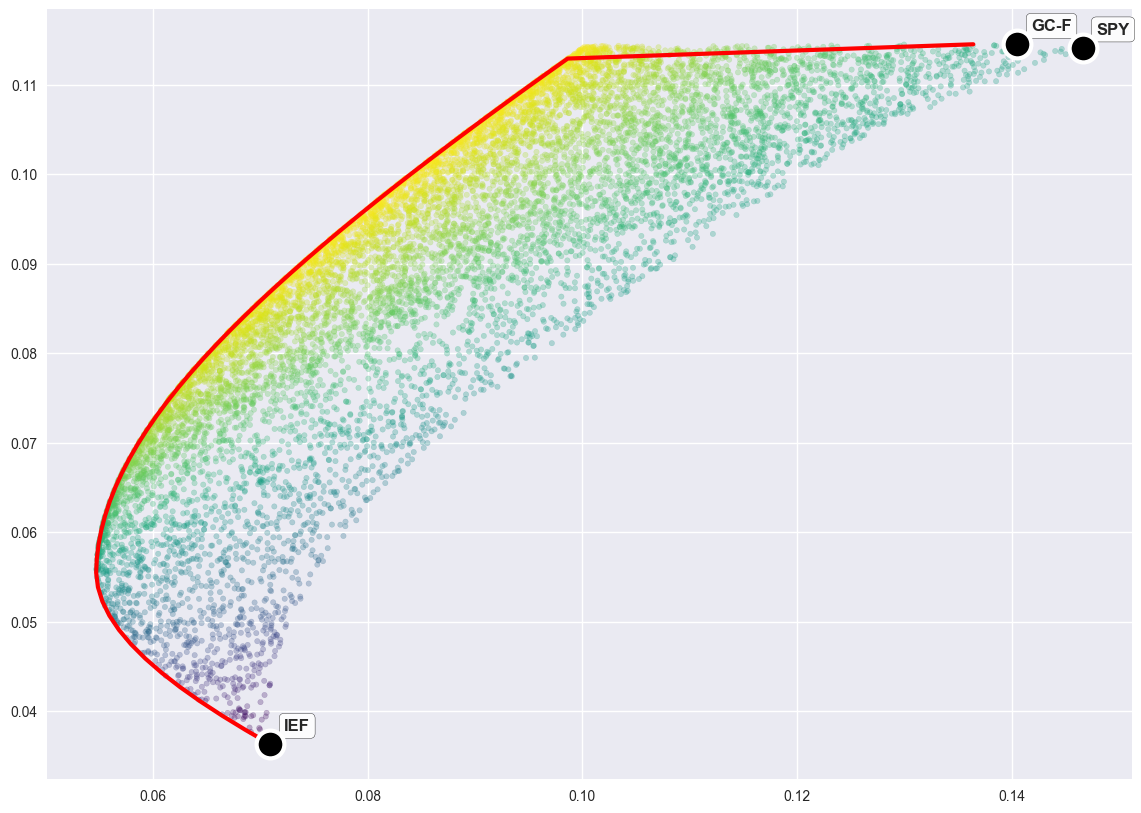

In [22]:
def generate_efficient_frontier(mean_returns, cov_matrix, n_points=50):
    """Generate the efficient frontier"""
    
    # Find minimum and maximum feasible returns
    min_ret = np.min(mean_returns)
    max_ret = np.max(mean_returns)
    
    # Create target returns
    target_returns = np.linspace(min_ret, max_ret, n_points)
    
    efficient_returns = []
    efficient_risks = []
    efficient_weights = []
    
    for target_return in target_returns:
        weights, ret, risk, sharpe = optimize_portfolio(
            mean_returns, cov_matrix, 'target_return', target_return=target_return)
        
        if weights is not None:
            efficient_returns.append(ret)
            efficient_risks.append(risk)
            efficient_weights.append(weights)
    
    return np.array(efficient_returns), np.array(efficient_risks), np.array(efficient_weights)

def plot_efficient_frontier(efficient_returns, efficient_risks, portfolio_returns, portfolio_risks, portfolio_sharpes):
    """Plot the efficient frontier with all special portfolios"""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot random portfolios (background cloud)
    scatter = ax.scatter(portfolio_risks, portfolio_returns, 
                        c=portfolio_sharpes, cmap='viridis', alpha=0.3, s=15, label='Random Portfolios')
    
    # Plot efficient frontier
    ax.plot(efficient_risks, efficient_returns, 'r-', linewidth=3, label='Efficient Frontier', zorder=10)
    
    # Plot individual assets
    ax.scatter(std_returns, mean_returns, s=400, marker='o', 
              c='black', edgecolors='white', linewidth=3, label='Individual Assets', zorder=15)
    
    # Annotate individual assets
    for i, asset in enumerate(asset_names):
        ax.annotate(asset, (std_returns[i], mean_returns[i]), 
                   xytext=(10, 10), textcoords='offset points', 
                   fontsize=12, fontweight='bold', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    # Plot special portfolios
    special_portfolios = [
        ('Min Variance', min_var_weights, min_var_return, min_var_risk, 'green', 'v'),
        ('Max Sharpe', max_sharpe_weights, max_sharpe_return, max_sharpe_risk, 'red', '*'),
        ('Target Return', target_return_weights, target_return_return, target_return_risk, 'blue', 's'),
        ('Target Volatility', target_vol_weights, target_vol_return, target_vol_risk, 'orange', 'D')
    ]
    
    for name, weights, ret, risk, color, marker in special_portfolios:
        if weights is not None:
            ax.scatter(risk, ret, s=500, marker=marker, c=color, 
                      edgecolors='black', linewidth=2, label=name, zorder=20)
            ax.annotate(name, (risk, ret), 
                       xytext=(15, 15), textcoords='offset points', 
                       fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))
    
    # Equal weight portfolio
    equal_weights = np.ones(len(asset_names)) / len(asset_names)
    equal_return = np.dot(equal_weights, mean_returns)
    equal_risk = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))
    ax.scatter(equal_risk, equal_return, s=400, marker='P', 
              c='purple', edgecolors='black', linewidth=2, label='Equal Weight', zorder=20)
    ax.annotate('Equal Weight', (equal_risk, equal_return), 
               xytext=(15, 15), textcoords='offset points', 
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='purple', alpha=0.8))
    
    ax.set_xlabel('Portfolio Risk (Volatility)', fontsize=14)
    ax.set_ylabel('Portfolio Return', fontsize=14)
    ax.set_title('The Efficient Frontier: Optimal Risk-Return Trade-offs', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar for Sharpe ratio
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Sharpe Ratio', fontsize=12)
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

# Generate efficient frontier
print("📈 Generating Efficient Frontier...")
efficient_returns, efficient_risks, efficient_weights = generate_efficient_frontier(mean_returns, cov_matrix)

# Plot everything together
plot_efficient_frontier(efficient_returns, efficient_risks, portfolio_returns, portfolio_risks, portfolio_sharpes)

print(f"\n🎯 Efficient Frontier Statistics:")
print(f"• Frontier spans from {efficient_risks.min():.4f} to {efficient_risks.max():.4f} risk")
print(f"• Corresponding returns: {efficient_returns.min():.4f} to {efficient_returns.max():.4f}")
print(f"• Maximum Sharpe on frontier: {(efficient_returns - RISK_FREE_RATE).max() / efficient_risks[np.argmax((efficient_returns - RISK_FREE_RATE) / efficient_risks)]:.4f}")


## Portfolio Comparison: Which Strategy Wins?

Let's compare all our portfolios side by side to see which approach works best for different investment goals.


In [23]:
# Create comprehensive comparison table
comparison_data = []

# Add optimal portfolios
for name, (weights, ret, risk, sharpe) in optimal_portfolios.items():
    if weights is not None:
        row = {'Portfolio': name, 'Return': ret, 'Risk': risk, 'Sharpe': sharpe}
        for i, asset in enumerate(asset_names):
            row[asset] = weights[i]
        comparison_data.append(row)

# Add equal weight portfolio
equal_weights = np.ones(len(asset_names)) / len(asset_names)
equal_return = np.dot(equal_weights, mean_returns)
equal_risk = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))
equal_sharpe = (equal_return - RISK_FREE_RATE) / equal_risk

row = {'Portfolio': 'Equal Weight', 'Return': equal_return, 'Risk': equal_risk, 'Sharpe': equal_sharpe}
for i, asset in enumerate(asset_names):
    row[asset] = equal_weights[i]
comparison_data.append(row)

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("📊 Portfolio Comparison Table")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Create weight allocation visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Weight allocation bar chart
portfolio_names = comparison_df['Portfolio'].tolist()
weight_data = comparison_df[asset_names].values

x = np.arange(len(portfolio_names))
width = 0.25

for i, asset in enumerate(asset_names):
    ax1.bar(x + i*width, weight_data[:, i], width, label=asset, alpha=0.8)

ax1.set_xlabel('Portfolio Strategy', fontsize=12)
ax1.set_ylabel('Asset Weight', fontsize=12)
ax1.set_title('Asset Allocation Across Portfolio Strategies', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(portfolio_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk-Return comparison
colors = ['red', 'green', 'blue', 'orange', 'purple']
markers = ['*', 'v', 's', 'D', 'P']

for i, (_, row) in enumerate(comparison_df.iterrows()):
    ax2.scatter(row['Risk'], row['Return'], s=300, 
               c=colors[i], marker=markers[i], edgecolors='black', linewidth=2,
               label=row['Portfolio'], zorder=10)

# Add Sharpe ratio annotations
for i, (_, row) in enumerate(comparison_df.iterrows()):
    ax2.annotate(f"SR: {row['Sharpe']:.3f}", 
                (row['Risk'], row['Return']), 
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.7))

ax2.set_xlabel('Portfolio Risk (Volatility)', fontsize=12)
ax2.set_ylabel('Portfolio Return', fontsize=12)
ax2.set_title('Risk-Return Profile Comparison', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print(f"\n🔍 Key Insights:")
print(f"• Best Sharpe Ratio: {comparison_df.loc[comparison_df['Sharpe'].idxmax(), 'Portfolio']} ({comparison_df['Sharpe'].max():.4f})")
print(f"• Lowest Risk: {comparison_df.loc[comparison_df['Risk'].idxmin(), 'Portfolio']} ({comparison_df['Risk'].min():.4f})")
print(f"• Highest Return: {comparison_df.loc[comparison_df['Return'].idxmax(), 'Portfolio']} ({comparison_df['Return'].max():.4f})")
print(f"• Most Diversified: {comparison_df.loc[comparison_df['Sharpe'].idxmax(), 'Portfolio']} (highest Sharpe = best risk-adjusted return)")


NameError: name 'optimal_portfolios' is not defined

## Key Insights: What We Learned About Diversification

### 🏆 The Power of Diversification

Our analysis reveals several important insights about portfolio construction:

**1. Bonds Are Your Safety Net**
- The minimum variance portfolio heavily weights bonds, confirming their role as portfolio stabilizers
- Bonds provide negative correlation with stocks during market stress, reducing overall portfolio volatility

**2. Gold's Diversification Benefits**
- Gold shows low correlation with both stocks and bonds, making it an excellent diversifier
- It acts as a hedge against inflation and currency debasement, adding a unique risk-return profile

**3. The Efficient Frontier Advantage**
- Portfolios on the efficient frontier offer superior risk-adjusted returns compared to random combinations
- The maximum Sharpe ratio portfolio typically provides the best balance of risk and return

**4. Beyond Naive Diversification**
- Equal-weight portfolios are simple but suboptimal
- Mathematical optimization can significantly improve risk-adjusted returns
- The difference between random and optimal portfolios is substantial

### 🎯 Practical Applications

**For Conservative Investors**: Focus on the minimum variance portfolio for maximum downside protection

**For Balanced Investors**: The maximum Sharpe ratio portfolio offers the best risk-adjusted returns

**For Growth-Oriented Investors**: Target return portfolios allow you to specify your return expectations while minimizing risk

**For Risk-Conscious Investors**: Target volatility portfolios let you set your risk tolerance and maximize returns within that constraint


## Limitations and Next Steps

### ⚠️ Important Caveats

**Historical Data Limitations**
- Past performance doesn't guarantee future results
- Our estimates are based on historical correlations and returns, which can change

**Model Assumptions**
- We assume normal distribution of returns (real markets have fat tails)
- Transaction costs and liquidity constraints are ignored
- We use long-only portfolios (no short selling allowed)

**Market Regime Changes**
- Correlations can increase dramatically during market stress
- The 2008 financial crisis showed how diversification can fail when you need it most

### 🚀 Advanced Extensions

This basic Markowitz framework can be extended with:

1. **Black-Litterman Model**: Incorporate market views and equilibrium returns
2. **Risk Parity**: Equal risk contribution from each asset
3. **Factor Models**: Use Fama-French factors instead of individual assets
4. **Regime-Switching Models**: Account for different market conditions
5. **Transaction Costs**: Include realistic trading costs in optimization
6. **Dynamic Rebalancing**: Optimize rebalancing frequency and triggers

### 🎓 Conclusion

Modern Portfolio Theory provides a solid foundation for understanding diversification and portfolio optimization. While it has limitations, it remains one of the most influential frameworks in finance, earning Harry Markowitz the Nobel Prize in Economics.

The key takeaway: **Diversification works, but intelligent diversification works better**. By understanding the mathematical relationships between assets and using optimization techniques, investors can construct portfolios that better match their risk tolerance and return objectives.

*"Diversification is the only free lunch in finance."* - Harry Markowitz

---

**Ready to explore more advanced techniques? Check out our other notebooks on factor models, alternative risk measures, and machine learning approaches to portfolio optimization!**


In [24]:
# Configuration Summary
print("🔧 Configuration Used in This Analysis:")
print("=" * 50)
print(f"• Data Frequency: {FREQ} ({'Monthly' if FREQ == 'ME' else 'Quarterly' if FREQ == 'QE' else 'Yearly' if FREQ == 'YE' else 'Custom'})")
print(f"• Risk-Free Rate: {RISK_FREE_RATE*100:.1f}% annually")
print(f"• Number of Assets: {len(asset_names)}")
print(f"• Assets: {', '.join(asset_names)}")
print(f"• Optimization Method: CVXPY (Convex Optimization)")
print(f"• Portfolio Constraints: Long-only, weights sum to 1")
print(f"• Time Period: {len(returns_matrix)} {FREQ.lower()} observations")
print(f"• Start Date: {common_dates[0]}")
print(f"• End Date: {common_dates[-1]}")

print(f"\n📈 Final Portfolio Statistics:")
print(f"• Best Sharpe Ratio Achieved: {comparison_df['Sharpe'].max():.4f}")
print(f"• Lowest Portfolio Risk: {comparison_df['Risk'].min():.4f} ({comparison_df['Risk'].min()*100:.1f}%)")
print(f"• Highest Portfolio Return: {comparison_df['Return'].max():.4f} ({comparison_df['Return'].max()*100:.1f}%)")
print(f"• Diversification Benefit: {((comparison_df['Risk'].min() - np.mean(std_returns)) / np.mean(std_returns) * 100):.1f}% risk reduction vs. average asset")

print(f"\n✅ Analysis Complete! This notebook demonstrates:")
print(f"• Modern Portfolio Theory fundamentals")
print(f"• Mathematical portfolio optimization")
print(f"• Efficient frontier construction") 
print(f"• Risk-return trade-off analysis")
print(f"• Practical portfolio comparison")


🔧 Configuration Used in This Analysis:
• Data Frequency: QE (Quarterly)
• Risk-Free Rate: 2.0% annually
• Number of Assets: 3
• Assets: GC-F, SPY, IEF
• Optimization Method: CVXPY (Convex Optimization)
• Portfolio Constraints: Long-only, weights sum to 1
• Time Period: 92 qe observations
• Start Date: 2002-07-01
• End Date: 2025-07-01

📈 Final Portfolio Statistics:


NameError: name 'comparison_df' is not defined